# Lab Assignment Seven: Sequential Network Architectures
In this lab, you will select a prediction task to perform on your dataset, evaluate a sequential architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify.

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

## Dataset Selection

Select a dataset that is text. That is, the dataset should be text data. In terms of generalization performance, it is helpful to have a medium sized dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification should be "many-to-one" sequence classification.



## Preparation (3 points total)
[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  
[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

## Modeling (6 points total)
[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.
[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations.
[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

## Exceptional Work (1 points total)
You have free reign to provide additional analyses.
One idea (required for 7000 level students to do one of these options):
Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application?

In [42]:
!pip install tensorflow_addons


In [43]:
import subprocess
import platform
import os
import itertools
import time
from IPython.display import display, HTML, Markdown, clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clear_screen():
    time.sleep(2)
    print("Clearing screen...")
    time.sleep(2)
    clear_output()

clear_screen()

In [44]:
import pandas as pd
import zipfile
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Selection

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset


This dataset contains 5,574 English SMS messages labeled as spam or not spam (ham). The dataset contains one message per line. Each line is composed of two columns the label and the textual data. The label in this data set is a binary classifier with results of either ham or spam. Therefore representing a many-to-one relationship. This dataset originally labeled the columns v1 for the label and v2 for the raw text data. To provide readability to our code we changed the column names to be labeled label and text respectively.


Acknowledgments
The original dataset can be found here.

Reference to previous paper: Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.
Reference to web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/


In [45]:
# Read in our dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Lab7_ML/spam 2.csv", encoding='latin1')

# Renaming the columns for readability purposes
df.rename(columns={'v1': 'Label'}, inplace=True)
df.rename(columns={'v2': 'Text'}, inplace=True)

df.head()


,Label,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Dataset Details

No additional features were added.

In [46]:
def print_df_list_of_features():
    columns = df.columns.to_list()
    features = "Features: "
    for i, col in enumerate(columns):
        if i > 0:
            features += f', "{col}"'
        else:
            features += f'"{col}"'
    print(features)

print_df_list_of_features()

Features: "Label", "Text", "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"


In [47]:
# Prints the size of the dataframe to output
rows, columns = df.shape
print(f"The dataset contains {rows} rows and {columns} columns.\n")

The dataset contains 5572 rows and 5 columns.



## Handeling Missing Data

In the cells below you can see that the columns labeled 'Unnamed: 2', 'Unnamed: 3', and 'Unnamed: 4' are ~99.8 % null values.

Due to the extensive amount of null values in these columns, we decided to remove them to avoid unnecessary noise in our dataset. In doing this we will improve our training time by reducing the size of the dataset and increase our model's ability to learn the relationships between features.





In [48]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(str(missing_values)+ "\n")

print("These are the columns with missing data:" + str(df.columns[df.isnull().any()].tolist()))

Missing Values:
Label            0
Text             0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

These are the columns with missing data:['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']


In [49]:
# Prints a list of columns that are filled with null values
# Here you can see there are non-null values in these columns but it is less than 1 % of the data within the entire dataset.
# Therefore our group chose to delete them to improve our models performance.

print(df.columns[df.isnull().all()])

print(df['Unnamed: 2'].str.cat(sep=''))

df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

Index([], dtype='object')
 PO Box 5249 the person is definitely special for u..... But if the person is so special HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\"" wanted to say hi. HI!!!\" Stop? Send STOP to 62468"this wont even start........ Datz confidence.." PO Box 5249GN.;-):-D"just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\"" bt not his girlfrnd... G o o d n i g h t . . .@" I'll come up" don't miss ur best life for anything... Gud nyt..." just as a shop has to give a guarantee on what they sell. B. G." But at d end my love compromised me for everything:-(\".. Gud mornin:-)" the toughest is acting Happy with all unspoken pain inside..\"" smoke hella weed\""\" not \"what i need to do.\""JUST GOT PAYED2DAY & I HAVBEEN GIVEN Aå£50 PAY RISE 4MY WORK & HAVEBEEN MADE PRESCHOOLCO-ORDINATOR 2I AM FEELINGOOD LUV\"" justthought iåÕd sayhey! how u doin?nearly the endof me wk offdam nevamind!We will have 2Hook up sn if uwant m8? loveJen x.\""JUST REALLYNEE

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


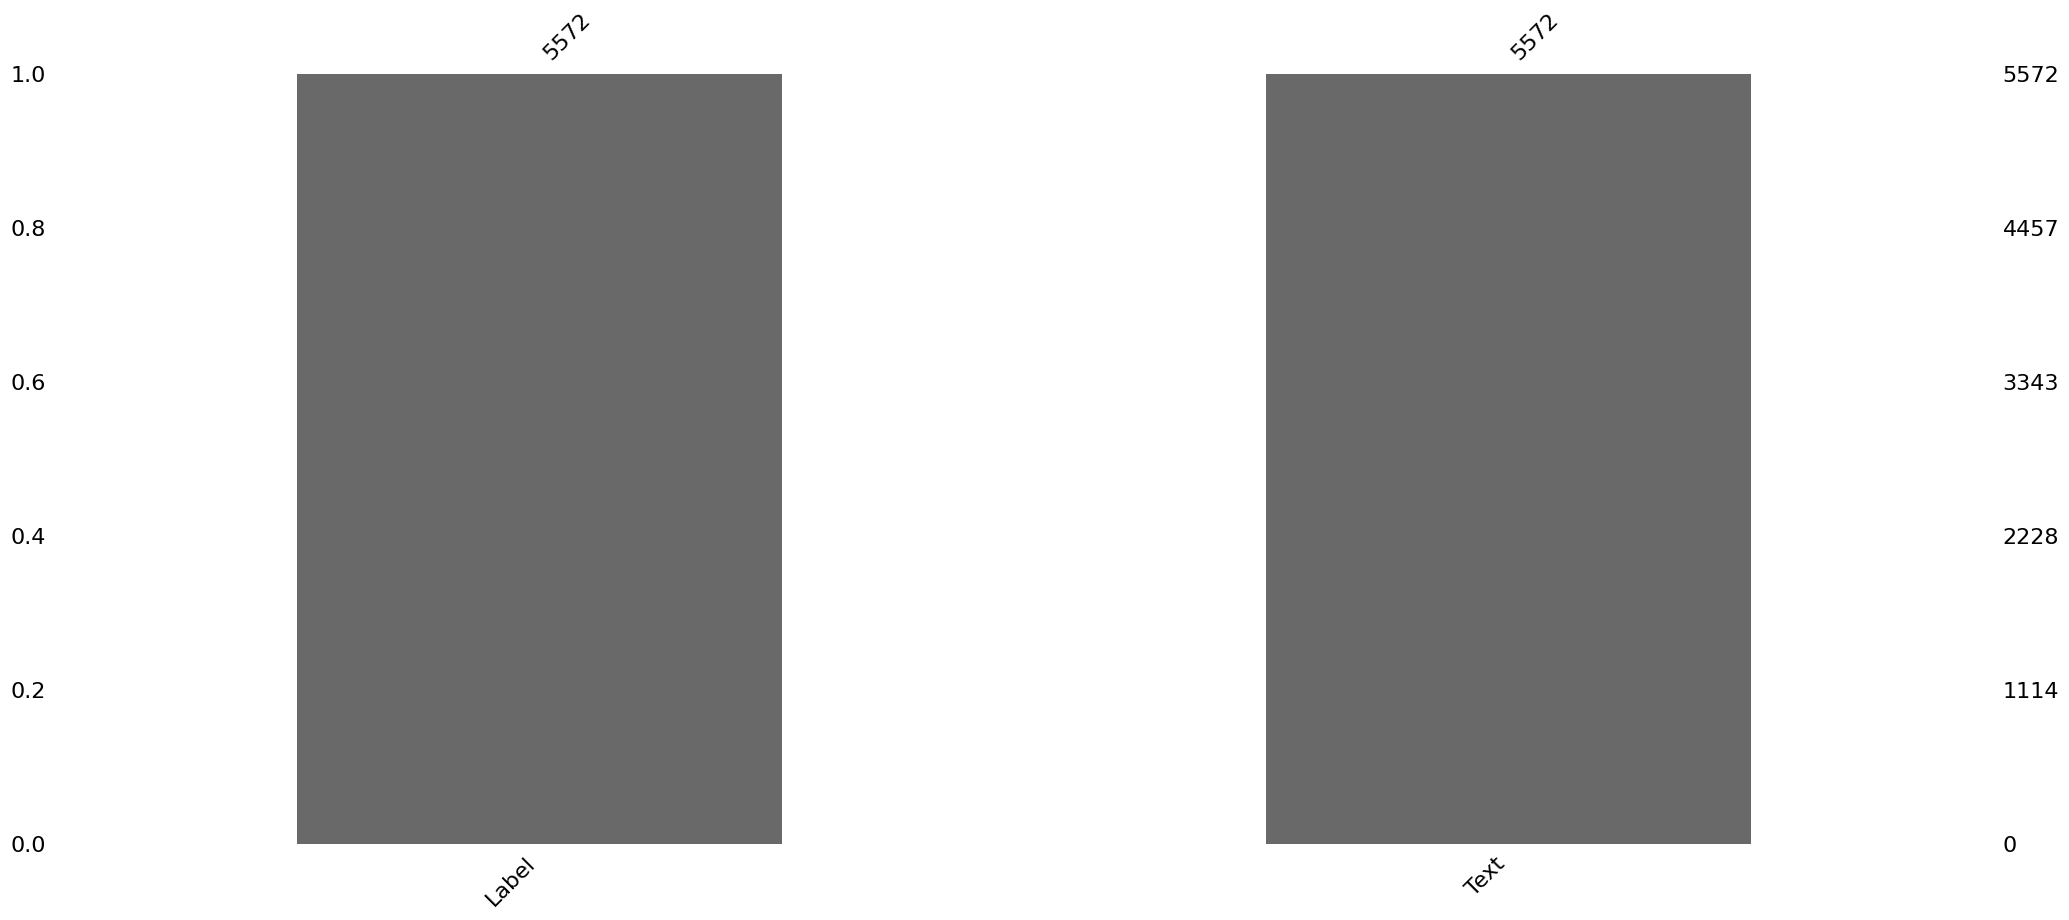

In [50]:
# Final dataset with no missing values.

import missingno as msno

msno.bar(df)

df.head()

## Check for Duplicates


In [51]:
def check_for_duplicate_entries():
    return df.duplicated().any()


print(
    "Duplicates Found!"
) if check_for_duplicate_entries() is True else print("No Duplicates Found!")

No Duplicates Found!


### Dataset Types

In the cell below you can see our dataset is in text format. It will be one hot encoded in the following cells to ensure the ability to run sequential networks!

In [52]:
# Prints the datatypes for each column
print("Datatypes")
print(df.dtypes)

Datatypes
Label    object
Text     object
dtype: object


## Data Preparation

The **first step** in preprocessing our data for sequential networks is to remove any irrelevant information such as **stopwords** and convert all the text to lowercase to ensure consistency. In the cell below you can see we removed the stop words from the Text column in our dataframe.

In [53]:
# Removing stop words from the text column.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




**The second step is to tokenize the data. **
Tokenizing the data is breaking the text into a sequence of tokens. These tokens are often words or charecters in the dataset. It is important to tokenize a dataset to reduce the dimensionality of the dataset making the network easier to learn! Tokenizing the dataset can also emphasize the important parts of the text which can therefore improve the accuracy of the network's prediction. Lastly, tokenizing the dataset can help improve the stability of a dataset byt making the dataset more consistent.

In the cells below you can see we created a new column called tokenizedText that represents the tokenized version of the SMS data.

In [54]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
# Funtion returns all tokens in lowercase.
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [56]:
# Function return list of tokens from SMS messages column df['Text']
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    tokens = to_lowercase(tokens)
    return [w for w in tokens if w.isalpha()]

In [57]:
df['tokenizedText'] = df.apply(lambda x: tokenize(x['Text']), axis=1)
df[['tokenizedText']].head()

,tokenizedText
0,"[go, jurong, point, crazy, available, bugis, n..."
1,"[ok, lar, joking, wif, u, oni]"
2,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,"[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, i, think, goes, usf, lives, around, though]"


In [58]:
print(df.dtypes)

Label            object
Text             object
tokenizedText    object
dtype: object


**The third step is to force a specific length on our dataset. **
To force a specific length of sequence on your dataset you can use the pad_sequences() function from the keras preprocessing library. This function takes a max length argument and either truncates your sequences or adds zeros to force a specific length on the dataset.

In the cell below we first calculate the longest sequence in our tokenized dataset. The longest sequence in our dataset came out to be 85 tokens. In the cells following we will pad the sequences that have below 85 tokens using the keras preprocessing library!




In [59]:
def getMaxLength(df):
  return max(len(x) for x in df['tokenizedText'])

In [60]:
# Create a tokenizer
# Fit the tokens to the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokenizedText'])

# Convert the text to sequences of integers
x = tokenizer.texts_to_sequences(df['tokenizedText'])

# Get the maximum length of the sequences
max_length = getMaxLength(df)

# Pad the sequences to the maximum length
# So we can send them through a  neural network
padded = pad_sequences(x, maxlen=max_length)

# Print the padded dataset
print(padded)

[[   0    0    0 ...   15 3683   82]
 [   0    0    0 ...  382    2 1686]
 [   0    0    0 ...  132   76  325]
 ...
 [   0    0    0 ...   38  459 7278]
 [   0    0    0 ...  892  149   12]
 [   0    0    0 ...  105  408  204]]


**The last step is to one-hot encode the labels. **

Since our labels are categorical values of spam or not spam (also known as ham) it is important to convert these values to binary values. The label will take on a value of 1 if the vector is spam and a 0 if it is ham.

It is important to one-hot encode categorical values in our dataset to ensure our model can learn the relationship between the different categories.


In [61]:
from keras.utils import to_categorical

# Prints the unique labels
print("These are the unique labels in our dataset. We need to change these values to be one hot encoded. ")
print(df['Label'].nunique())
print(df['Label'].unique())
print()

one_hot_encoded_data = pd.get_dummies(df, columns = ['Label'])
print("This is the new dataset!")
print(one_hot_encoded_data.dtypes)

# one hot encoding labels
#one_hot_labels = to_categorical(df['Label'])

#print(one_hot_labels)



These are the unique labels in our dataset. We need to change these values to be one hot encoded. 
2
['ham' 'spam']

This is the new dataset!
Text             object
tokenizedText    object
Label_ham         uint8
Label_spam        uint8
dtype: object


## Evaluation Method



For evaluating our model's performance, we will be using recall. Between the two types of classifications spam and ham it is important to avoid marking possibly important messages as spam/junk mail. Misclassification of text messages could lead to dissatisfaction and the loss of important information. For example, a missing credit card statement, an appointment reminder, a package delivery, and much more. Therefore our models will be evaluated on their ability to positively classify these messages as spam or ham.

Beyond recall, we use metrics such as accuracy, misclassificaiton, precision, recall, and F1-score to measure and compare algorithm performance.

Accuracy is a measure of the overall correctness of a model's predictions, calculated as the ratio of the number of correct predictions to the total number of predictions.

Misclass, or misclassification, refers to the instances where a model's prediction does not match the actual class label of a data point.

Precision is a measure of how well a model correctly identifies positive instances among the predicted positive instances.

Recall, also known as sensitivity or the true positive rate, is a measure of how well a model identifies all the positive instances among the actual positive instances.

F1-score is the "harmonic mean" of precision and recall, providing a single value that balances the trade-off between precision and recall.


Additionally, we will evaluate the performance of a sequential network based on its training time and computational resources required. It is important to take into consideration the amount of time and resources our models will need because we want to avoid crashing the messaging device while predicting if a message is spam or ham.  


We want to consider all of these metrics since not only do we want our models to perform well, but we want to achieve the highest true positive rate for both classes as possible.

## Dataset Splitting

Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

In [83]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train_ham, X_test_ham, y_train_ham, y_test_ham = train_test_split(one_hot_encoded_data['Label_ham'], one_hot_encoded_data['tokenizedText'], test_size=0.25)
X_train_spam, X_test_spam, y_train_spam, y_test_spam = train_test_split(one_hot_encoded_data['Label_spam'], one_hot_encoded_data['tokenizedText'], test_size=0.25)

## Modeling


In [94]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

#https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
# Create model
cnn = Sequential()

# Add model layers
cnn.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28,28,1)))
cnn.add(Conv2D(32, kernel_size=3, activation="relu"))
cnn.add(Flatten())
cnn.add(Dense(10, activation="softmax"))

print(cnn.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 flatten_8 (Flatten)         (None, 18432)             0         
                                                                 
 dense_13 (Dense)            (None, 10)                184330    
                                                                 
Total params: 203434 (794.66 KB)
Trainable params: 203434 (794.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [91]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
#Train the model

X_train_ham = tf.convert_to_tensor(X_train_ham)
y_train_ham = tf.convert_to_tensor(y_train_ham)

model.fit(X_train_ham, y_train_ham, validation_data=(X_test_ham, y_test_ham), epochs=3)

ValueError: ignored